# Importign required modules

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train transformations
train_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
  ])

# Test transformations
test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
  ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 124697705.07it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 43216444.46it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37209819.09it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23432384.71it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

SEED = 1
# To reproduce the same results across the sessions
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)
  dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
else:
  dataloader_args = dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Stats
Calculating the mean and standard deviation of the data.

Just for understanding the data.

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train data]
 - Numpy Shape: (28, 60000, 28)
 - Tensor Shape: torch.Size([28, 60000, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


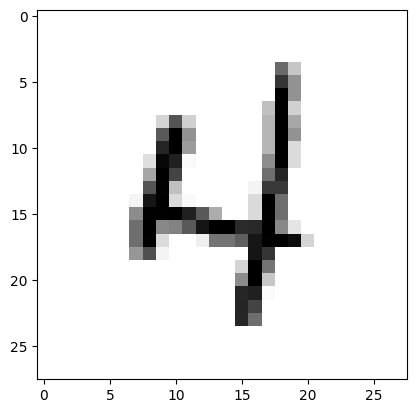

In [5]:
# Convert back tensors back to Numpy
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train data]')
print(' - Numpy Shape:', train_data.numpy().shape)
print(' - Tensor Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

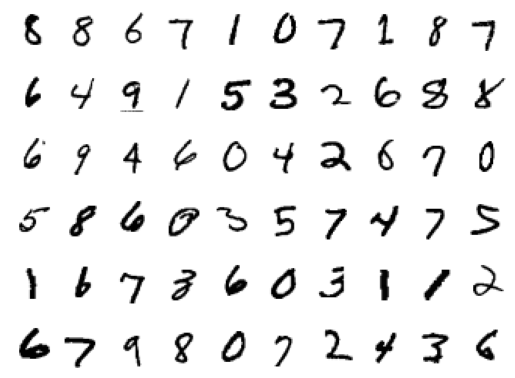

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Data Stats2
The previous block provided statistics for a normalized dataset, resulting in a mean of zero and a standard deviation of one. In this block, we obtain the mean and standard deviation for the raw, unnormalized data.

This step is not necessary if we already have prior knowledge of the mean and standard deviation of the dataset

In [7]:
# simple transform
simple_transforms = transforms.Compose([transforms.ToTensor(),])

exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp_data.numpy().shape)
print(' - Tensor Shape:', exp_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (28, 60000, 28)
 - Tensor Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# Model

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26


        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11


        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7


        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7) # 7>> 9... nn.AdaptiveAvgPool((1, 1))
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [24]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1, 10,

In [25]:
from tqdm import tqdm

# Aggregate loss and accuracy
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get batch data
    data, target = data.to(device), target.to(device)

    # Reset all gradients to zero
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Do calculate the grads in dackpropagation
    loss.backward()

    # Update the model weights
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Aggregate batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Update total test data loss
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Training & Testing

In [26]:
# Creat the mode and move it to CUDA
model = Net().to(device)

# Using stochastic gradient descent method for optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 25
for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.33069202303886414 Batch_id=468 Accuracy=82.50: 100%|██████████| 469/469 [00:18<00:00, 24.96it/s]



Test set: Average loss: 0.4220, Accuracy: 9257/10000 (92.57%)

EPOCH: 1


Loss=0.2018638402223587 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:18<00:00, 25.93it/s]



Test set: Average loss: 0.4900, Accuracy: 8581/10000 (85.81%)

EPOCH: 2


Loss=0.1295657902956009 Batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]



Test set: Average loss: 0.2857, Accuracy: 9254/10000 (92.54%)

EPOCH: 3


Loss=0.20464569330215454 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:18<00:00, 25.31it/s]



Test set: Average loss: 0.1681, Accuracy: 9597/10000 (95.97%)

EPOCH: 4


Loss=0.0541611909866333 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:18<00:00, 24.82it/s]



Test set: Average loss: 0.2128, Accuracy: 9385/10000 (93.85%)

EPOCH: 5


Loss=0.08653640747070312 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:18<00:00, 25.58it/s]



Test set: Average loss: 0.1983, Accuracy: 9442/10000 (94.42%)

EPOCH: 6


Loss=0.12615473568439484 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]



Test set: Average loss: 0.1366, Accuracy: 9649/10000 (96.49%)

EPOCH: 7


Loss=0.036924105137586594 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:18<00:00, 25.26it/s]



Test set: Average loss: 0.1302, Accuracy: 9649/10000 (96.49%)

EPOCH: 8


Loss=0.05243266746401787 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]



Test set: Average loss: 0.1238, Accuracy: 9660/10000 (96.60%)

EPOCH: 9


Loss=0.04828435555100441 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:18<00:00, 24.89it/s]



Test set: Average loss: 0.1269, Accuracy: 9637/10000 (96.37%)

EPOCH: 10


Loss=0.056689709424972534 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:18<00:00, 25.47it/s]



Test set: Average loss: 0.1162, Accuracy: 9699/10000 (96.99%)

EPOCH: 11


Loss=0.03875792399048805 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]



Test set: Average loss: 0.0980, Accuracy: 9723/10000 (97.23%)

EPOCH: 12


Loss=0.10829327255487442 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:18<00:00, 24.90it/s]



Test set: Average loss: 0.0763, Accuracy: 9821/10000 (98.21%)

EPOCH: 13


Loss=0.07421496510505676 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]



Test set: Average loss: 0.0895, Accuracy: 9759/10000 (97.59%)

EPOCH: 14


Loss=0.050416380167007446 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:18<00:00, 25.08it/s]



Test set: Average loss: 0.0913, Accuracy: 9736/10000 (97.36%)

EPOCH: 15


Loss=0.05318192020058632 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:18<00:00, 25.58it/s]



Test set: Average loss: 0.0884, Accuracy: 9752/10000 (97.52%)

EPOCH: 16


Loss=0.09786956757307053 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]



Test set: Average loss: 0.0908, Accuracy: 9728/10000 (97.28%)

EPOCH: 17


Loss=0.03916109353303909 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:19<00:00, 24.31it/s]



Test set: Average loss: 0.0860, Accuracy: 9756/10000 (97.56%)

EPOCH: 18


Loss=0.09448090195655823 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:19<00:00, 24.35it/s]



Test set: Average loss: 0.1043, Accuracy: 9687/10000 (96.87%)

EPOCH: 19


Loss=0.055804941803216934 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]



Test set: Average loss: 0.0710, Accuracy: 9811/10000 (98.11%)

EPOCH: 20


Loss=0.030266322195529938 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:18<00:00, 25.40it/s]



Test set: Average loss: 0.0852, Accuracy: 9748/10000 (97.48%)

EPOCH: 21


Loss=0.04358484968543053 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:19<00:00, 24.61it/s]



Test set: Average loss: 0.0808, Accuracy: 9743/10000 (97.43%)

EPOCH: 22


Loss=0.02154972217977047 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:19<00:00, 24.22it/s]



Test set: Average loss: 0.0750, Accuracy: 9782/10000 (97.82%)

EPOCH: 23


Loss=0.048069123178720474 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:19<00:00, 24.54it/s]



Test set: Average loss: 0.0812, Accuracy: 9773/10000 (97.73%)

EPOCH: 24


Loss=0.05527162551879883 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]



Test set: Average loss: 0.0757, Accuracy: 9789/10000 (97.89%)



# Plot the Results

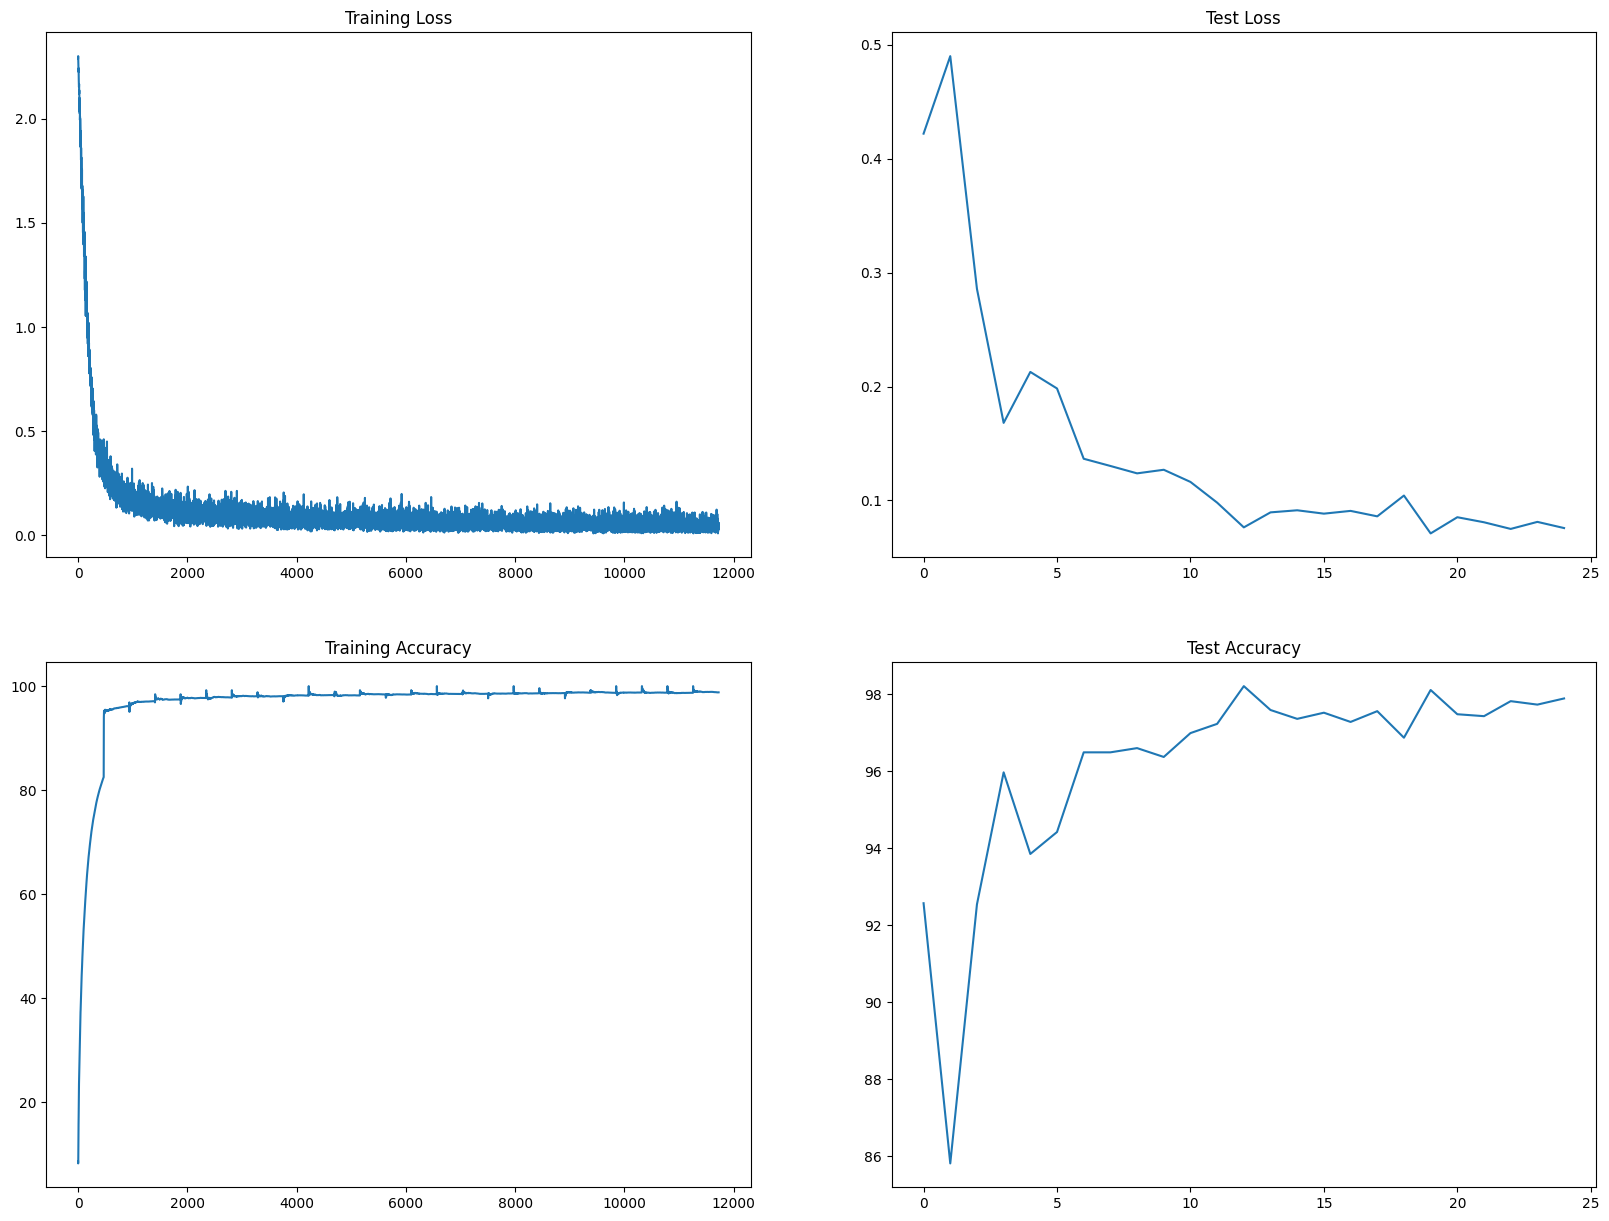

In [28]:
t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(20,15))

axs[0, 0].set_title("Training Loss")
axs[0, 0].plot(t)

axs[1, 0].set_title("Training Accuracy")
axs[1, 0].plot(train_acc)

axs[0, 1].set_title("Test Loss")
axs[0, 1].plot(test_losses)

axs[1, 1].set_title("Test Accuracy")
axs[1, 1].plot(test_acc)

# Iteration 6
---
##Target:
*   Using GAP to reduce the total parameters by avoiding the Big kernel at the end.

##Results:
*   Total params: 6,070
*   Best Training Accuracy: 98.72% (Till 20th Epoch)
*   Best Test Accuracy: 98.11% (Till 20th Epoch)

##Analysis:
*   Using Global Avg Pooling as the last layer instead of a large kernel (7 x 7) reduces the total parameters of the model to around 6K.
*   Due to the significant difference in the parameter count, it is not an apples-to-apples comparison when comparing the accuracies with the previous model.
*   The drop in performance can be attributed to the drop in total parameteres.



